In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import recall_score, make_scorer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.metrics import fbeta_score, make_scorer
from fmri_processing import *


def train_best_model_by_recall(train_matrix, target_class=1, random_state=42, verbose=True):
    # 1. Загрузка данных
    matrix = np.load(train_matrix)
    X = matrix
    
    # Создание меток (4-й ответ в каждом блоке из 5 - ложный)
    labels = np.zeros(X.shape[0], dtype=int)
    labels[3::5] = 1  
    
    # Группы для валидации (по испытуемым)
    groups = np.repeat(np.arange(X.shape[0] // 5), 5)

    # 2. Пайплайн с ADASYN
    def create_pipeline(model):
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('adasyn', ADASYN(random_state=random_state)),  # <-- Изменено здесь
            ('feature_selector', 'passthrough'),
            ('model', model)
        ])

    # 3. Модели и параметры (без изменений)
    models = {
        "Logistic Regression": {
            'pipeline': create_pipeline(LogisticRegression(max_iter=1000)),
            'params': {
                'feature_selector': [
                    SelectFromModel(LogisticRegression(penalty='l1', solver='saga', random_state=random_state)),
                    PCA(n_components=0.95)
                ],
                'model__C': [0.1, 1, 10, 100],
                'model__class_weight': ['balanced', None],
                'model__solver': ['lbfgs', 'saga', 'liblinear']
            }
        },
        "Random Forest": {
            'pipeline': create_pipeline(RandomForestClassifier()),
            'params': {
                'feature_selector': [
                    SelectFromModel(RandomForestClassifier(random_state=random_state)),
                    RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=50)
                ],
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [None, 10, 20],
                'model__class_weight': ['balanced_subsample', None]
            }
        },
        "SVM": {
            'pipeline': create_pipeline(SVC(probability=True)),
            'params': {
                'feature_selector': [PCA(n_components=0.95)],
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf'],
                'model__class_weight': ['balanced']
            }
        },
        "XGBoost": {
            'pipeline': create_pipeline(XGBClassifier()),
            'params': {
                'feature_selector': [SelectFromModel(XGBClassifier(random_state=random_state))],
                'model__n_estimators': [100, 200],
                'model__max_depth': [3, 5, 7],
                'model__learning_rate': [0.01, 0.1, 0.2],
                'model__subsample': [0.8, 1.0]
            }
        }
    }

    # 4. Обучение с групповой валидацией (без изменений)
    optimized_models = {}
    # recall_scorer = make_scorer(recall_score, pos_label=target_class)
    # balanced_acc_scorer = make_scorer(balanced_accuracy_score)
    f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=target_class)

    for name, config in models.items():
        cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
        gs = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['params'],
            cv=cv_strategy,
            scoring=f2_scorer,
            n_jobs=-1,
            verbose=0
        )
        gs.fit(X, labels, groups=groups)
        optimized_models[name] = gs.best_estimator_
        
        if verbose:
            print(f"{name} - Лучшие параметры: {gs.best_params_}")
            print(f"Recall (CV): {gs.best_score_:.3f}\n")

    # 6. Создание стекинг-ансамбля (без изменений)
    ensemble = StackingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        final_estimator=SVC(max_iter=1000, class_weight='balanced'),
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # 7. Оценка ансамбля с ADASYN
    logo = LeaveOneGroupOut()
    # balanced_acc_scores = []
    f2_scores = []
    
    for train_idx, val_idx in logo.split(X, labels, groups=groups):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Обучаем модель на оригинальных данных без балансировки
        ensemble.fit(X_train, y_train)
        y_pred = ensemble.predict(X_val)
        
        # Сохраняем метрики
        f2_scores.append(balanced_accuracy_score(y_val, y_pred))
    
    if verbose:
        print(f"Ансамбль (ADASYN) - Recall: {np.mean(f2_scores):.3f} ± {np.std(f2_scores):.3f}")
    
    return {'models': optimized_models, 'ensemble': ensemble.fit(X, labels)}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeaveOneGroupOut, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import recall_score, make_scorer, balanced_accuracy_score, fbeta_score
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from fmri_processing.utils import draw_heat_map
from fmri_processing.functions import funcs
import os
from fmri_processing import *

def train_best_model_by_recall(train_matrix, target_class=1, random_state=42, verbose=True):
    # 1. Загрузка данных
    matrix = np.load(train_matrix)
    X = matrix
    
    # Создание меток (4-й ответ в каждом блоке из 5 - ложный)
    labels = np.zeros(X.shape[0], dtype=int)
    labels[3::5] = 1  
    
    # Группы для валидации (по испытуемым)
    groups = np.repeat(np.arange(X.shape[0] // 5), 5)

    # 2. Пайплайн с ADASYN
    def create_pipeline(model):
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('adasyn', ADASYN(random_state=random_state)),
            ('feature_selector', 'passthrough'),
            ('dim_reducer', 'passthrough'),
            ('model', model)
        ])

    # 3. Расширенный список моделей с параметрами
    models = {
        "Logistic Regression": {
            'pipeline': create_pipeline(LogisticRegression(max_iter=1000)),
            'params': {
                'feature_selector': [
                    SelectFromModel(LogisticRegression(penalty='l1', solver='saga', random_state=random_state)),
                    PCA(n_components=0.95)
                ],
                'dim_reducer': [None, PCA(n_components=50)],
                'model__C': [0.1, 1, 10, 100],
                'model__class_weight': ['balanced', None],
                'model__solver': ['lbfgs', 'saga', 'liblinear']
            }
        },
        "Random Forest": {
            'pipeline': create_pipeline(RandomForestClassifier()),
            'params': {
                'feature_selector': [
                    SelectFromModel(RandomForestClassifier(random_state=random_state)),
                    RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=50)
                ],
                'dim_reducer': [None, PCA(n_components=0.8)],
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [None, 10, 20],
                'model__class_weight': ['balanced_subsample', None]
            }
        },
        "SVM": {
            'pipeline': create_pipeline(SVC(probability=True)),
            'params': {
                'feature_selector': [PCA(n_components=0.95)],
                'dim_reducer': [None],
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf'],
                'model__class_weight': ['balanced']
            }
        },
        "XGBoost": {
            'pipeline': create_pipeline(XGBClassifier()),
            'params': {
                'feature_selector': [SelectFromModel(XGBClassifier(random_state=random_state))],
                'dim_reducer': [None],
                'model__n_estimators': [100, 200],
                'model__max_depth': [3, 5, 7],
                'model__learning_rate': [0.01, 0.1, 0.2],
                'model__subsample': [0.8, 1.0]
            }
        },
        "CatBoost": {
            'pipeline': create_pipeline(CatBoostClassifier(verbose=0)),
            'params': {
                'feature_selector': [None, SelectFromModel(CatBoostClassifier(verbose=0))],
                'dim_reducer': [None],
                'model__iterations': [100, 200],
                'model__depth': [4, 6],
                'model__learning_rate': [0.03, 0.1]
            }
        },
        "Neural Network": {
            'pipeline': create_pipeline(MLPClassifier()),
            'params': {
                'feature_selector': [PCA(n_components=0.95)],
                'dim_reducer': [None],
                'model__hidden_layer_sizes': [(100,), (50,50)],
                'model__alpha': [0.0001, 0.001],
                'model__learning_rate_init': [0.001, 0.01]
            }
        },
        "Gradient Boosting": {
            'pipeline': create_pipeline(GradientBoostingClassifier()),
            'params': {
                'feature_selector': [SelectFromModel(GradientBoostingClassifier())],
                'dim_reducer': [None],
                'model__n_estimators': [100, 200],
                'model__learning_rate': [0.05, 0.1],
                'model__max_depth': [3, 5]
            }
        },
        "k-NN": {
            'pipeline': create_pipeline(KNeighborsClassifier()),
            'params': {
                'feature_selector': [PCA(n_components=0.8)],
                'dim_reducer': [None],
                'model__n_neighbors': [3, 5, 7],
                'model__weights': ['uniform', 'distance']
            }
        },
        "AdaBoost": {
            'pipeline': create_pipeline(AdaBoostClassifier()),
            'params': {
                'feature_selector': [None],
                'dim_reducer': [None],
                'model__n_estimators': [50, 100],
                'model__learning_rate': [0.8, 1.0]
            }
        },
        "Hist Gradient Boosting": {
            'pipeline': create_pipeline(HistGradientBoostingClassifier()),
            'params': {
                'feature_selector': [None],
                'model__learning_rate': [0.05, 0.1],
                'model__max_iter': [100, 200],
                'model__max_depth': [None, 10]
            }
        },
        "QDA": {
            'pipeline': create_pipeline(QuadraticDiscriminantAnalysis()),
            'params': {
                'feature_selector': [PCA(n_components=0.9)],
                'model__reg_param': [0.0, 0.1, 0.5]
            }
        },
        "Extra Trees": {
            'pipeline': create_pipeline(ExtraTreesClassifier()),
            'params': {
                'feature_selector': [SelectFromModel(ExtraTreesClassifier())],
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 10],
                'model__class_weight': ['balanced_subsample']
            }
        }
    }

    # 4. Обучение с групповой валидацией
    optimized_models = {}
    grid_searches = {}
    f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=target_class)

    for name, config in models.items():
        cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
        gs = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['params'],
            cv=cv_strategy,
            scoring=f2_scorer,
            n_jobs=-1,
            verbose=0
        )
        gs.fit(X, labels, groups=groups)
        optimized_models[name] = gs.best_estimator_
        grid_searches[name] = gs
        
        if verbose:
            print(f"{name} - Лучшие параметры: {gs.best_params_}")
            print(f"F2-Score (CV): {gs.best_score_:.3f}\n")

    # # 5. Визуализация
    # if verbose:
    #     for model_name, model in optimized_models.items():
    #         try:
    #             importances = model.named_steps['model'].feature_importances_
    #             plt.figure(figsize=(12, 6))
    #             plt.bar(range(len(importances)), importances)
    #             plt.title(f"Важность признаков ({model_name})")
    #             plt.xlabel("Номер региона мозга")
    #             plt.ylabel("Важность")
    #             plt.show()
    #         except AttributeError:
    #             if 'PCA' in model.named_steps:
    #                 pca = model.named_steps['dim_reducer']
    #                 plt.figure(figsize=(12, 6))
    #                 plt.plot(np.cumsum(pca.explained_variance_ratio_))
    #                 plt.title(f"Накопленная дисперсия (PCA) - {model_name}")
    #                 plt.xlabel("Число компонент")
    #                 plt.ylabel("Дисперсия")
    #                 plt.grid(True)
    #                 plt.show()

    # 6. Создание ансамблей
    # Стекинг
    stacking_ensemble = StackingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        final_estimator=LogisticRegression(class_weight='balanced'),
        stack_method='auto',
        passthrough=True,
        n_jobs=-1
    )
    
    # Взвешенное голосование
    best_scores = {name: gs.best_score_ for name, gs in grid_searches.items()}
    weights = np.array([best_scores[name] for name in optimized_models.keys()])
    weights /= weights.sum()  # Нормализация весов

    voting_ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        voting='soft',
        weights=weights,
        n_jobs=-1
    )

    # 7. Оценка ансамблей
    logo = LeaveOneGroupOut()
    stacking_scores = []
    voting_scores = []
    
    for train_idx, val_idx in logo.split(X, labels, groups=groups):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Обучение и оценка стекинга
        stacking_ensemble.fit(X_train, y_train)
        stacking_pred = stacking_ensemble.predict(X_val)
        stacking_scores.append(fbeta_score(y_val, stacking_pred, beta=2, pos_label=target_class))
        
        # Обучение и оценка голосования
        voting_ensemble.fit(X_train, y_train)
        voting_pred = voting_ensemble.predict(X_val)
        voting_scores.append(fbeta_score(y_val, voting_pred, beta=2, pos_label=target_class))
    
    if verbose:
        print(f"Stacking Ensemble - F2-Score: {np.mean(stacking_scores):.3f} ± {np.std(stacking_scores):.3f}")
        print(f"Voting Ensemble - F2-Score: {np.mean(voting_scores):.3f} ± {np.std(voting_scores):.3f}")
    
    return {
        'models': optimized_models,
        'stacking_ensemble': stacking_ensemble.fit(X, labels),
        'voting_ensemble': voting_ensemble.fit(X, labels)
    }

In [16]:
def train_and_predict_on_test(train_matrix, test_matrix):
    models = train_best_model_by_recall(train_matrix)
    # model = models['models']['SVM']
    model = models['ensemble']
    # model = models
    matrix_test = np.load(test_matrix)
    # evaluate_and_plot(test_matrix=test_matrix, trained_model=model)
    
    N_test = matrix_test.shape[0]  # Длина массива

    labels_test = np.zeros(N_test, dtype=int)  # Создаем массив из нулей
    labels_test[3::5] = 1  # Каждый 4-й элемен
    print(classification_report(labels_test, model.predict(matrix_test)))
    return

def train_different_params(train_matrix_base, test_matrix_base):
    for func_name in funcs.keys():
        if func_name in ('max_min', 'min', 'auc'):
            continue
        train_matrix = os.path.join(train_matrix_base, func_name + '.npy')
        test_matrix = os.path.join(test_matrix_base, func_name + '.npy')

        train_and_predict_on_test(train_matrix, test_matrix)

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def evaluate_and_plot(test_matrix, trained_model, random_state=42):
    # 1. Загрузка тестовых данных
    X_test = np.load(test_matrix)
    
    # 2. Создание тестовых меток
    labels_test = np.zeros(X_test.shape[0], dtype=int)
    labels_test[3::5] = 1
    
    # 3. Получение предсказаний ансамбля
    ensemble = trained_model['models']['SVM']
    y_pred = ensemble.predict(X_test)
    y_proba = ensemble.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

    # 4. Confusion Matrix
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        labels_test, 
        y_pred,
        display_labels=['Real', 'Fake'],
        cmap='Blues',
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')

    # 5. ROC-кривая
    fpr, tpr, _ = roc_curve(labels_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    ax[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc='lower right')
    
    plt.show()

    # 6. Визуализация в пространстве признаков (PCA)
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X_test)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        X_pca[:, 0], 
        X_pca[:, 1], 
        c=y_pred, 
        cmap='viridis',
        alpha=0.6,
        label='Predicted'
    )
    
    # Отметим ошибочные предсказания
    errors = y_pred != labels_test
    plt.scatter(
        X_pca[errors, 0], 
        X_pca[errors, 1], 
        edgecolors='red',
        facecolors='none',
        s=100,
        label='Errors'
    )
    
    plt.legend()
    plt.title('PCA Projection with Predictions')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    # 7. Отчет классификации
    print(classification_report(labels_test, y_pred, target_names=['Real', 'Fake']))

# Просто баллы

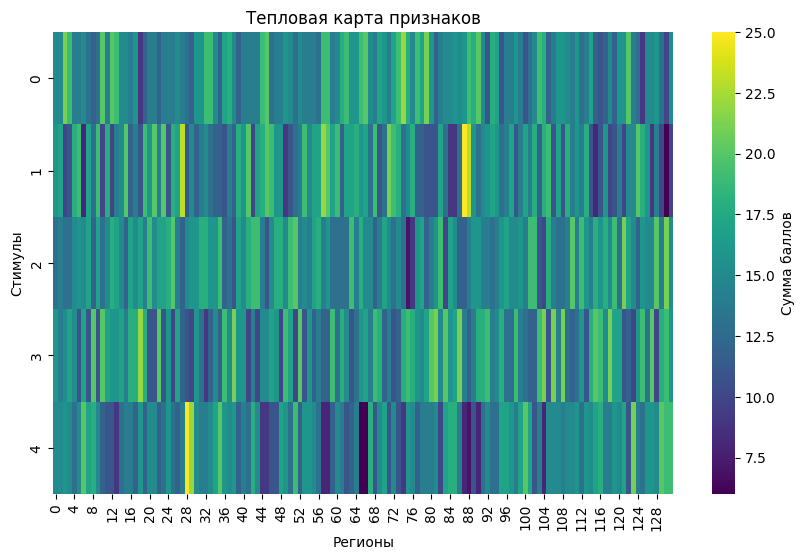

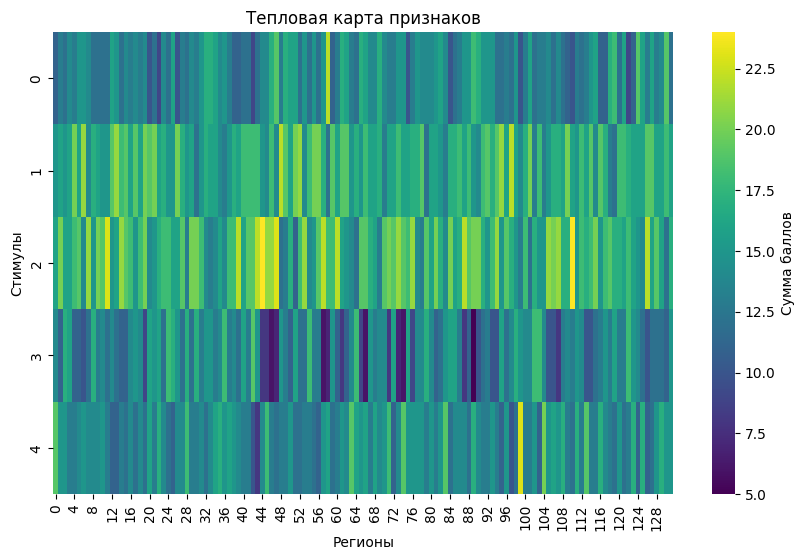

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Logistic Regression - Лучшие параметры: {'feature_selector': SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='saga')), 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}
Recall (CV): 0.733

Random Forest - Лучшие параметры: {'feature_selector': RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=50), 'model__class_weight': 'balanced_subsample', 'model__max_depth': 10, 'model__n_estimators': 100}
Recall (CV): 0.722

SVM - Лучшие параметры: {'feature_selector': PCA(n_components=0.95), 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__kernel': 'rbf'}
Recall (CV): 0.570

XGBoost - Лучшие параметры: {'feature_selector': SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                            

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

KeyboardInterrupt: 

In [20]:
ranks_train_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_hc_data'
ranks_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_test_data'
ranks_schz_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_schz_data'
ranks_card_hc_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_card_hc_data'
ranks_card_test_matrix = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/raw_card_test_data'
# train - test
# train_different_params(ranks_train_matrix, ranks_test_matrix)

draw_heat_map(np.load(os.path.join(ranks_test_matrix, 'max.npy')))
draw_heat_map(np.load(os.path.join(ranks_train_matrix, 'max.npy')))

# test - train
train_different_params(ranks_test_matrix, ranks_train_matrix)

# test - schz
# train_different_params(ranks_test_matrix, ranks_schz_matrix)

# train - card
# train_different_params(ranks_test_matrix, ranks_card_test_matrix)


# Баллы 1-2

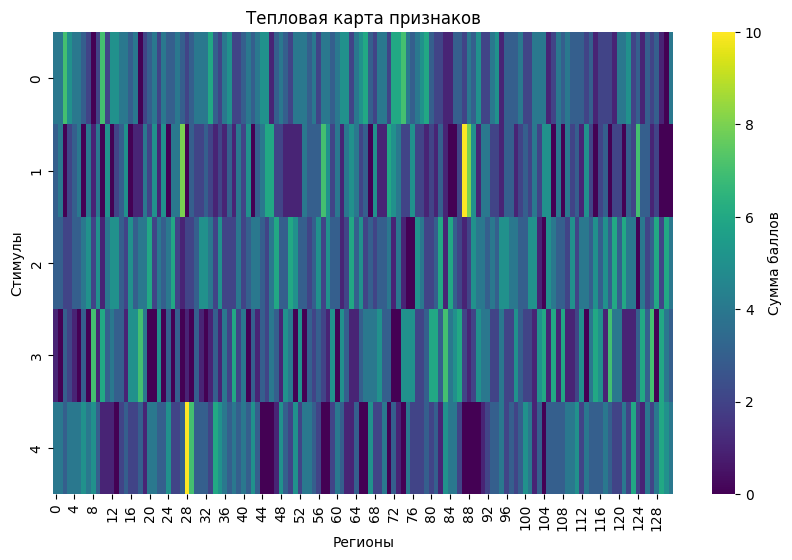

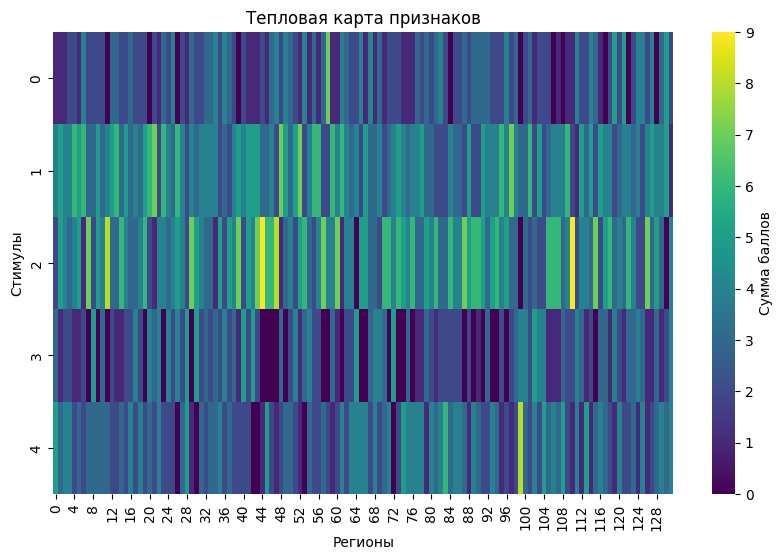

In [21]:
reduced_train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_hc_data'
reduced_test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_test_data'
draw_heat_map(np.load(os.path.join(reduced_test_matrix_base, 'max.npy')))
draw_heat_map(np.load(os.path.join(reduced_train_matrix_base, 'max.npy')))

reduced_schz_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_schz_data'

reduced_cards_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/ranks_matrix/reduced_ranks/raw_card_hc_data'

# train - test 
# train_different_params(reduced_train_matrix_base, reduced_test_matrix_base)

# test - train
# train_different_params(reduced_test_matrix_base, reduced_train_matrix_base)

# test - schz
# train_different_params(reduced_train_matrix_base, reduced_schz_matrix_base)

# train_different_params(reduced_train_matrix_base, reduced_schz_matrix_base)

# train_different_params(reduced_train_matrix_base, reduced_cards_matrix_base)

# Усреднение стимула

In [61]:
train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/hc_data'
test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/test_data'

schz_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/schz_data'
card_train_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_hc_data'
card_test_matrix_base = '/home/aaanpilov/diploma/project/numpy_matrixes/average_stimulus/card_test_data'

# train_different_params(train_matrix_base, card_train_matrix_base)
# print('SCHZ'*20)

# train - test
# train_different_params(train_matrix_base, test_matrix_base)

# test - train
# train_different_params(test_matrix_base, train_matrix_base)

# test - schz
train_different_params(test_matrix_base, schz_matrix_base)

# train_different_params(train_matrix_base, card_train_matrix_base)

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Logistic Regression - Лучшие параметры: {'feature_selector': PCA(n_components=0.95), 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'liblinear'}
Recall (CV): 0.804

Random Forest - Лучшие параметры: {'feature_selector': SelectFromModel(estimator=RandomForestClassifier(random_state=42)), 'model__class_weight': 'balanced_subsample', 'model__max_depth': None, 'model__n_estimators': 200}
Recall (CV): 0.489

SVM - Лучшие параметры: {'feature_selector': PCA(n_components=0.95), 'model__C': 1, 'model__class_weight': 'balanced', 'model__kernel': 'rbf'}
Recall (CV): 0.633

XGBoost - Лучшие параметры: {'feature_selector': SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
 

In [ ]:
def draw_all_subjects(matrix):
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5

    subjects = np.array_split(matrix, sub_num)
    for idx, sub in enumerate(subjects):
        print(f'sub-{idx:02d}')
        draw_heat_map(subjects[idx]
                      )